### Module 14: Learning Notebook: SVMs & Pipeline
**Data:**<P>
This is gene measurements trying to predict which type of cancer the patient was diagnosed. All patients had cancer, but the question is: Can we predict the right type?:
    
- One of 5 classes: ['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD']
<BR>

It is interesting because there are more than 20,000 dimensions (columns) and only 800 samples (rows). <P>
    
When you have 'high-dimensional data' (lots of columns), the SVM algorithms can be quite good.<P>
- data: http://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq

**New Algorithm: Support Vector Machines (SVM):**

SVM is a supervised machine learning algorithm that can be employed for both classification and regression purposes. Mostly, SVMs are used for classification.
    
SVMs can do both binary and mutliclass classification. In our case, we are trying to predict one of 5 classes. So, this is called "multiclass classification."   
 
SVMs are based on the idea of finding a **hyperplane** that best divides a dataset into two classes, as shown in the image below.  Support vectors are the data points nearest to the hyperplane, the points of a data set that, if removed, would alter the position of the dividing hyperplane. Because of this, they can be considered the critical elements of a data set.<P>
    
<img src="images/svm2.png" alt="SVM" style="width: 400px;"/><P>

Pros:
- Works relatively well when there is a clear margin of separation between classes.
- More effective in high dimensional spaces (many features)
- Is effective in cases where the number of dimensions is greater than the number of samples.
- Is relatively memory efficient

Cons
- Isn’t suited to larger datasets as the training time with SVMs can be high
- Less effective on noisier datasets with overlapping classes


In [14]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import pandas as pd
import numpy as np
import pickle
import time

### 1. Load and investigate the data


In [15]:
# Setup boto3
sess = boto3.session.Session()
s3 = sess.client('s3') 
source_bucket = 'machinelearning-read-only'
source_key = 'data/gene_expression_wide.pkl' 
response = s3.get_object(Bucket = source_bucket, Key = source_key)
#
body = response['Body'].read()
#
# Create a new pandas DataFrame using the pickle.loads() function
df = pickle.loads(body)
print('df size (rows, columns):',df.shape)
df.head(5)

df size (rows, columns): (801, 20532)


,target,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,PRAD,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,LUAD,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,PRAD,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,PRAD,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,BRCA,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [16]:
# This will be multiclassification
print('Unique values in target:', df['target'].unique().tolist())

Unique values in target: ['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD']


In [17]:
# Data types: Only the 'target' is a non-number
df.dtypes

target         object
gene_0        float64
gene_1        float64
gene_2        float64
gene_3        float64
               ...   
gene_20526    float64
gene_20527    float64
gene_20528    float64
gene_20529    float64
gene_20530    float64
Length: 20532, dtype: object

In [18]:
# Have a look at the scales of the features
df.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


### 2. Convert string class values to numbers

In [19]:
# From a previous lesson: use the map() function
# Create a dict to map cancer type to a number
class_num = {'PRAD': 0, 'LUAD': 1,'BRCA': 2, 'KIRC': 3, 'COAD':4}
# 
# Use the map() function to replace each value in a Series
df['target'] = df['target'].map(class_num) # overwrite the 'target' column
df.head(5)

,target,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,2,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


### 3. Create the training and test datasets

In [20]:
# Features
X = df.drop(['target'],axis = 1)
# Target
y = df['target']
# Split into train/test
# Reserve 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.20, random_state = 11)
# Verify the sizes of the split datasets
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (640, 20531)
y_train: (640,)
X_test: (161, 20531)
y_test: (161,)


### 4. Setup and Create the pipeline

In [21]:
# Create the scaler
norm_scaler = MinMaxScaler()
# Create the model
svm_mc = svm.SVC() # SVM classifier with default parameters
# Create the steps
steps = [('Normalizer', norm_scaler), ('SVM_classifier', svm_mc)]
#
# Create the pipeline
pipe = Pipeline(steps)
pipe # Show parameters

Pipeline(memory=None,
         steps=[('Normalizer', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('SVM_classifier',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

### 5. Transform data and train the model

In [22]:
# Now, perform the pipeline steps on the data
# The end result is a trained model
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('Normalizer', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('SVM_classifier',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

### 5. Evaluate performance

In [23]:
# Predict based on the X_test data
y_pred = pipe.predict(X_test)
# Calculate the accuracy
acc = pipe.score(X_test, y_test)
print('Accuracy based on test data:', acc)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD'], 
                     columns = ['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD'])
cm_df

Accuracy based on test data: 0.9875776397515528


,PRAD,LUAD,BRCA,KIRC,COAD
PRAD,26,0,1,0,0
LUAD,0,34,1,0,0
BRCA,0,0,50,0,0
KIRC,0,0,0,35,0
COAD,0,0,0,0,14


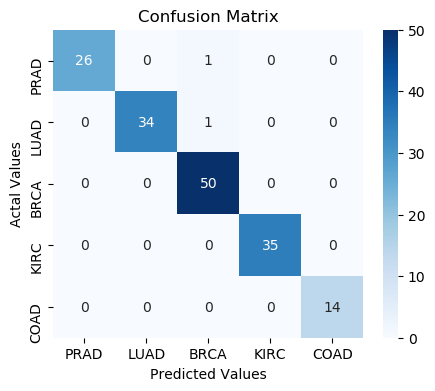

In [24]:
# Plot a fancy confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True,cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### This model may be overfit
Recall:
- Overfit means it is very good on predicting training data, but not on new, unseen data
    - We have more dimensions (columns) than samples (rows)
- Underfit means it is very generalizable, but may have high errors

What do do next? 

Maybe try a GridSearchCV to find the best 'kernel' and regularization parameter, 'C'. <P>

Recall:<P>
The 'C' hyperparameter is called regularization. Remember our discussion of overfitting vs underfitting? Overfitting means model is very focused on the training data and may not be good for unseen data. Underfitting means the model is too general and may have high error.<P>

You can control underfitting/overfitting using the C parameter in logistic regression.

- Default value of C = 1.0: A good place to start. C must be a positive float number
- Low value of C: high regulation (move away from overfitting)
- High value of C: low regularization (pay more attention to fitting the training data

The 'kernel' is the type of calculation model the algorithm uses. Possible types:
- 'rbf' (default)
- 'linear'
- 'poly'
- 'sigmoid'
- and a few other possibilities.
    
A good next step might be to tune the 'C' and 'kernel' hyperparameters.

### Warning, this cell will take longer than 15 minutes to run!

In [13]:
# # Define the range of parameters to evaluate
# parameters = {
#     "C":[.001, .01, .1, 1, 10], # default is C = 1.0
#     "kernel":['rbf', 'poly', 'linear', 'sigmoid'] # default = 'rbf'
#     }
# svmc_gs = svm.SVC()
# cv = GridSearchCV(svmc_gs,parameters,cv=5)
# #
# # Peform the grid search. This will take about 15 minutes on our default instant type
# start = time.time()
# print("Executing...")
# # Here it goes...
# cv.fit(X,y.values.ravel()) # Fit with the whole dataset (X,y)
# end = time.time()
# print(end - start, 'seconds')
# # Show the results of the search
# print('Best Score:', cv.best_score_)
# print('Best parameter values:', cv.best_params_)